### Processing Pipeline in SpaCy 

###### Watch Full Video Here: https://youtu.be/GI_2wmSK49I

When you call nlp on a text, spaCy first tokenizes the text to produce a Doc object. The Doc is then processed in several different steps – this is also referred to as the processing pipeline.

The pipeline used by the default models consists of a tagger, a parser and an entity recognizer. Each pipeline component returns the processed Doc, which is then passed on to the next component.

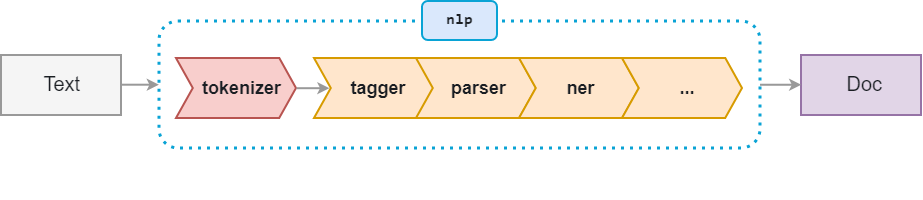

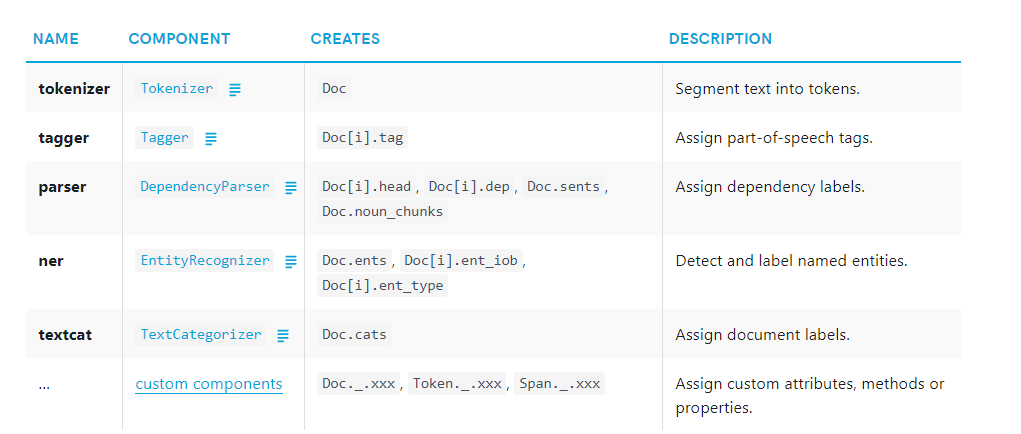

### Processing text 

When you call nlp on a text, spaCy will tokenize it and then call each component on the Doc, in order. It then returns the processed Doc that you can work with.

In [17]:
import spacy
from spacy.matcher import Matcher
from spacy.tokens import Span
from spacy import displacy

In [18]:
nlp = spacy.load("en_core_web_sm")

In [19]:
doc = nlp('This is raw text')

When processing large volumes of text, the statistical models are usually more efficient if you let them work on batches of texts. spaCy’s nlp.pipe method takes an iterable of texts and yields processed Doc objects. The batching is done internally.

In [4]:
texts = ["This is raw text", "There is lots of text"]

In [5]:
docs = list(nlp.pipe(texts))

#### Tips for efficient processing 
- Process the texts as a stream using nlp.pipe and buffer them in batches, instead of one-by-one. This is usually much more efficient.
- Only apply the pipeline components you need. Getting predictions from the model that you don’t actually need adds up and becomes very inefficient at scale. To prevent this, use the disable keyword argument to disable components you don’t need 

In this example, we’re using nlp.pipe to process a (potentially very large) iterable of texts as a stream. Because we’re only accessing the named entities in doc.ents (set by the ner component), we’ll disable all other statistical components (the tagger and parser) during processing. nlp.pipe yields Doc objects, so we can iterate over them and access the named entity predictions:

In [22]:
import spacy

texts = [
    "Net income was $9.4 million compared to the prior year of $2.7 million.",
    "Revenue exceeded twelve billion dollars, with a loss of $1b.",
]

nlp = spacy.load("en_core_web_sm")
docs = nlp.pipe(texts, disable=["tagger", "parser"])
for doc in docs:
    # Do something with the doc here
    print([(ent.text, ent.label_) for ent in doc.ents])
    print()

[('$9.4 million', 'MONEY'), ('the prior year', 'DATE'), ('$2.7 million', 'MONEY')]

[('twelve billion dollars', 'MONEY'), ('1b', 'MONEY')]



### How Pipelines Work 

spaCy makes it very easy to create your own pipelines consisting of reusable components – this includes spaCy’s default tagger, parser and entity recognizer, but also your own custom processing functions. A pipeline component can be added to an already existing nlp object, specified when initializing a Language class, or defined within a model package.

When you load a model, spaCy first consults the model’s meta.json. 

The meta typically includes the model details, the ID of a language class, and an optional list of pipeline components. spaCy then does the following:


- Load the language class and data for the given ID via `get_lang_class` and initialize it. The Language class contains the shared vocabulary, tokenization rules and the language-specific annotation scheme.

- Iterate over the pipeline names and create each component using `create_pipe`, which looks them up in Language.factories.
- Add each pipeline component to the pipeline in order, using `add_pipe`.

- Make the model data available to the Language class by calling `from_disk` with the path to the model data directory.

```
{
  "lang": "en",
  "name": "core_web_sm",
  "description": "Example model for spaCy",
  "pipeline": ["tagger", "parser", "ner"]
}
```

Fundamentally, a spaCy model consists of three components: the weights, i.e. binary data loaded in from a directory, a pipeline of functions called in order, and language data like the tokenization rules and annotation scheme.

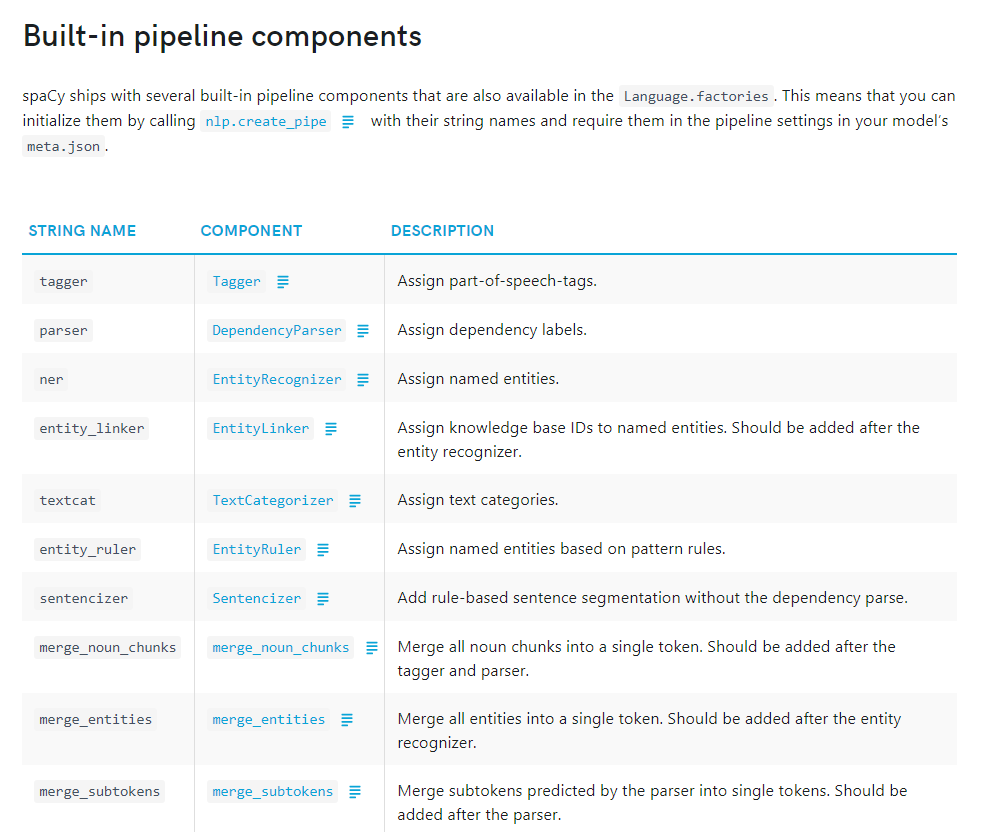

## Disabling and modifying pipeline components

If you don’t need a particular component of the pipeline – for example, the tagger or the parser, you can disable loading it. This can sometimes make a big difference and improve loading speed.

In [23]:
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser"])

In [24]:
nlp

In some cases, you do want to load all pipeline components and their weights, because you need them at different points in your application. However, if you only need a Doc object with named entities, there’s no need to run all pipeline components on it

In [25]:
doc = nlp("Apple is buying a startup")

In [26]:
for ent in doc.ents:
    print(ent.text, ent.label_)

Apple ORG


In [27]:
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "ner"])

In [28]:
doc = nlp("Apple is buying a startup")

In [29]:
for ent in doc.ents:
    print(ent.text, ent.label_)

In [30]:
nlp = spacy.load('en_core_web_sm')

In [31]:
# 1. Use as a contextmanager
with nlp.disable_pipes("tagger", "parser"):
    doc = nlp("I won't be tagged and parsed")
    doc = nlp("I will be tagged and parsed")


In [16]:
# 2. Restore manually
disabled = nlp.disable_pipes("ner")
doc = nlp("I won't have named entities")
disabled.restore()